In [1]:
# please use data_viz1 as your environment. data_viz0 is having some problems.

In [3]:
import dill
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral

import mdtraj as md

import matplotlib.pyplot as plt
from collections import Counter

import os
from typing import Optional, List

/home/bfd21/rds/hpc-work/miniconda3/envs/data_viz1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**First Order of Business:** let's see if our conditioning consistantly picked the correct loss strategy when presented with cyclic peptide data

In [4]:
strategies_batches = [
    f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_losses_selected_batch-{i}.pkl' for i in range(4)
]

strategies_list = []

for batch_str in strategies_batches:
    # Load from the file
    with open(batch_str, "rb") as f:
        loaded_list = dill.load(f)
    
    for j in loaded_list:
        strategies_list.append(j)

In [5]:
count = 0

for i in strategies_list:
    if i == strategies_list[0]:
        count += 1

print(count) # per the below output, it picked the correct outcome every single time.

400


**Nice! Now onto next objective:** We want to do PCA on the dihedral angles, maybe bond angles, on the generated samples, and compare where they lie in this PCA space to the raw validation data.

It should be noted that the below data, when conditioned on cyclicality, is merely conditioned right now on bond lengths. Dihedrals and bond angles are to come, and are fairly easy to implement from a programming perspective. However, I am still in the process of actually solving for said dihedrals with something like ORCA.

In [13]:
def generate_mdtraj_trajectory(pdb_path, data_files, print_shape = False):
    """
    Loads a PDB file, infers bonds, processes NPZ and NPY files, and constructs an MDTraj trajectory.

    Parameters:
        pdb_path (str): Path to the PDB file.
        data_files (list of str): List of paths to NPZ or NPY files containing sampled atomic positions.

    Returns:
        mdtraj.Trajectory: The generated trajectory with inferred bonds and centered coordinates.
    """

    # Load PDB and infer bonds
    pdb = md.load(pdb_path)
    pdb.topology.create_standard_bonds()  # Infer bonds based on atom types and residue connectivity
    topology = pdb.topology

    # Load and process generated samples
    all_samples = []
    for data_file in data_files:
        file_extension = os.path.splitext(data_file)[1]

        if file_extension == ".npz":
            data = np.load(data_file)
            samples_np = data["samples_np"]  # Extract the relevant array from NPZ
        elif file_extension == ".npy":
            samples_np = np.load(data_file)  # Load directly from NPY
        else:
            raise ValueError(f"Unsupported file format: {data_file}")

        # Reshape samples to match the number of atoms in the PDB
        n_atoms = len(list(topology.atoms))
        samples = samples_np.reshape(-1, n_atoms, 3)  # (n_frames, n_atoms, 3)
        all_samples.append(samples)

    # Combine all samples into a single array
    all_samples = np.concatenate(all_samples, axis=0)
    if print_shape:
        print(all_samples.shape)

    # Create an MDTraj trajectory with the inferred bonds
    traj = md.Trajectory(
        xyz=all_samples,  # Shape: (n_frames, n_atoms, 3)
        topology=topology
    )

    # Center the trajectory around the origin
    traj.center_coordinates()

    return traj

def compute_all_dihedrals(traj):
    """
    Computes backbone (phi, psi, omega) and side-chain (chi1, chi2, chi3, chi4) dihedral angles 
    for all amino acids in the given trajectory.
    
    Parameters:
        traj (mdtraj.Trajectory): MDTraj trajectory object.
    
    Returns:
        dict: Dictionary containing dihedral angles in degrees.
    """

    # Compute backbone dihedral angles
    phi_indices, phi_angles = md.compute_phi(traj)
    psi_indices, psi_angles = md.compute_psi(traj)
    omega_indices, omega_angles = md.compute_omega(traj)

    # Compute side-chain chi angles (some may be empty depending on the peptide)
    chi1_indices, chi1_angles = md.compute_chi1(traj)
    chi2_indices, chi2_angles = md.compute_chi2(traj)
    chi3_indices, chi3_angles = md.compute_chi3(traj)
    chi4_indices, chi4_angles = md.compute_chi4(traj)

    dihedral_angles = {
        "phi": phi_angles,
        "psi": psi_angles,
        "omega": omega_angles,
        "chi1": chi1_angles if chi1_angles.size else None,
        "chi2": chi2_angles if chi2_angles.size else None,
        "chi3": chi3_angles if chi3_angles.size else None,
        "chi4": chi4_angles if chi4_angles.size else None,
    }

    return dihedral_angles

default_keys = ['phi', 'omega', 'psi', 'chi1', 'chi2', 'chi3']

def concat_dihedrals(dihedrals_dict, keys = default_keys):
    # Concatenate along axis=1 to preserve n_samples while summing the second dimension
    all_dihedrals = np.concatenate([dihedrals_dict[key] for key in keys], axis=1) # shape should be (n_samples, n_dihedrals)

    return all_dihedrals

def data_to_dihedrals_vecs(pdb_path, data_files, keys = default_keys):
    '''Wraps generate_mdtraj_trajectory -> compute_all_dihedrals -> concat_dihedrals,
    for the sake of cleanliness.
    '''

    traj = generate_mdtraj_trajectory(pdb_path, data_files)
    dihedrals_dict = compute_all_dihedrals(traj)
    final_vecs = concat_dihedrals(dihedrals_dict, keys = keys)
    
    return final_vecs

################################################################
# unfortunately, I couldn't get sklearn to work in this env.
# therefore, I have just had chat GPT implement PCA in numpy
# Thanks, Chat GPT :)
################################################################

def pca_numpy(data, n_components: int):
    """
    Perform PCA using NumPy's eigenvalue decomposition.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        n_components (int): Number of principal components to keep.

    Returns:
        principal_components (numpy.ndarray): The principal component vectors (n_features, n_components).
        explained_variance (numpy.ndarray): Explained variance ratio of each principal component.
    """
    # Center the data
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # Compute covariance matrix
    covariance_matrix = np.cov(data_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]  # Sorted eigenvalues
    eigenvectors = eigenvectors[:, sorted_indices]  # Sorted eigenvectors

    # Compute explained variance ratio
    explained_variance = eigenvalues[:n_components] / np.sum(eigenvalues)

    # Select the top 'n_components' eigenvectors
    principal_components = eigenvectors[:, :n_components]

    return principal_components, explained_variance

def project_data(data, principal_components, center: np.array = None):
    """
    Projects data onto the given principal components.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        principal_components (numpy.ndarray): Principal components of shape (n_components, n_features).

    Returns:
        projected_data (numpy.ndarray): Data projected onto principal components of shape (n_samples, n_components).
    """
    # Center the data

    if center is not None:
        # center should be of shape (n_features, )
        data_centered = data - center
    else:
        data_centered = data

    # Compute projection: dot product with principal components
    projected_data = np.dot(data_centered, principal_components.T)  # Shape: (n_samples, n_components)

    return projected_data

def plot_pca_scatter(projected_data_list, colors, alpha=0.5, s=2, legend: Optional[List[str]] = None, title: Optional[str] = None):
    """
    Plots multiple PCA-projected datasets in 2D space with each dataset having its own color.

    Parameters:
        projected_data_list (list): A list of numpy arrays, each of shape (n_samples, 2), where each entry represents a PCA projection.
        colors (list): A list of colors, one for each dataset.
        alpha (float): Transparency of points (default 0.5).
        s (int): Size of points (default 2).
        legend (list): self explanatory
        title (str): self explanatory
    
    Returns:
        None (displays plot).
    """
    plt.figure(figsize=(8, 6))
    
    # Loop through the datasets and their corresponding colors
    for data, color in zip(projected_data_list, colors):
        plt.scatter(data[:, 0], data[:, 1], alpha=alpha, s=s, color=color)
    
    # Formatting
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection of Multiple Datasets")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Add horizontal axis
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Add vertical axis
    plt.grid(True, linestyle="--", alpha=0.5)
    if legend is not None:
        plt.legend(legend)
    if title is not None:
        plt.title(title)
    
    # Show plot
    plt.show()

**First Test:** We will compare where the conditionally generated samples lie in PCA space compared to the validation data

In [10]:
# This cell shall principly assemble all file names relevant to our analysis.

# pdb_path
pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb'

cond_cyc_unc_time_inference_list = [f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-{i}.npz' for i in range(4)]
#cond_cyc_cond_time_inference_list = # we will certainly want to add this later to our analysis, to see how conditioning on time changes the quality of the inference in PCA space.
unc_cyc_unc_time_inference_list = [f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-{i}.npz' for i in range(4)]
raw_validation_data = ['/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy']

**NB:** Below is some prior code which we found to generate an interesting plot.

In [7]:
traj = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                  data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',
                                                '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy',
                                                ],)
dihedrals_dict = compute_all_dihedrals(traj)
all_dihedrals = concat_dihedrals(dihedrals_dict) # we will use this to determine our PCA axes



traj_conditional = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                              data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',],)
dihedrals_dict_conditional = compute_all_dihedrals(traj_conditional)
conditional_dihedrals = concat_dihedrals(dihedrals_dict_conditional) # contains just the conditionally generated dihedrals

traj_raw = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                      data_files= ['/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy'])
dihedrals_dict_raw = compute_all_dihedrals(traj_raw)
raw_dihedrals = concat_dihedrals(dihedrals_dict_raw) # contains just the raw generated dihedrals

In [11]:
# Axes yielded by PCA analysis, which we will project out data onto.
pcs=[pca_numpy(all_dihedrals, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

center = np.mean(all_dihedrals, axis=0)

proj_raw = project_data(np.array(raw_dihedrals), pcs_arr, center= center) # (n_samples, n_features)
proj_cond = project_data(np.array(conditional_dihedrals), pcs_arr, center= center)

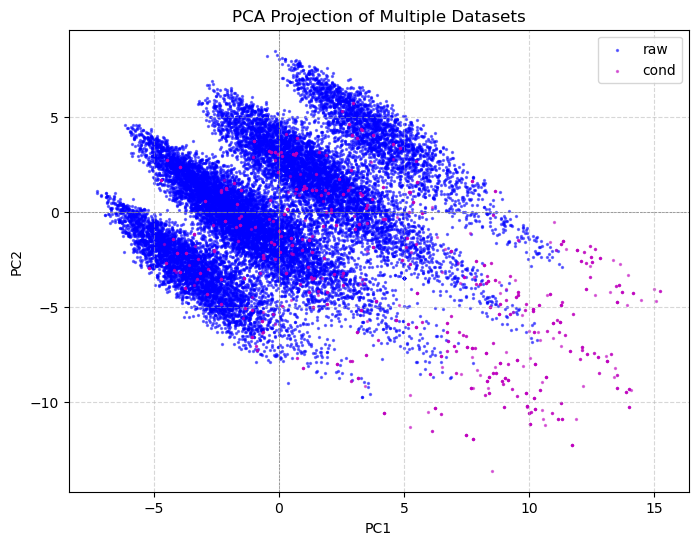

In [9]:
plot_pca_scatter([proj_raw, proj_cond], colors = ['b', 'm'], legend = ['raw', 'cond'])

**Second Test:** We will compare where the conditionally generated samples lie vs. the unconditionally generated ones

In [14]:
traj = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                  data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-0.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-1.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-2.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-3.npz',
                                                ],)
dihedrals_dict = compute_all_dihedrals(traj)
all_dihedrals = concat_dihedrals(dihedrals_dict) # we will use this to determine our PCA axes


traj_conditional = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                              data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',],)
dihedrals_dict_conditional = compute_all_dihedrals(traj_conditional)
conditional_dihedrals = concat_dihedrals(dihedrals_dict_conditional) # contains just the conditionally generated dihedrals



traj_unc = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                      data_files= ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-0.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-1.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-2.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-11/unconditioned-on-cyc/unconditioned-on-time/unc-cyc-unc-time-l1-inference_batch-3.npz',])
dihedrals_dict_unc = compute_all_dihedrals(traj_raw)
unc_dihedrals = concat_dihedrals(dihedrals_dict_raw) # contains just the raw generated dihedrals

In [16]:
# Axes yielded by PCA analysis, which we will project out data onto.
pcs=[pca_numpy(all_dihedrals, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

center = np.mean(all_dihedrals, axis=0)

proj_unc = project_data(np.array(unc_dihedrals), pcs_arr, center= center) # (n_samples, n_features)
proj_cond = project_data(np.array(conditional_dihedrals), pcs_arr, center= center)

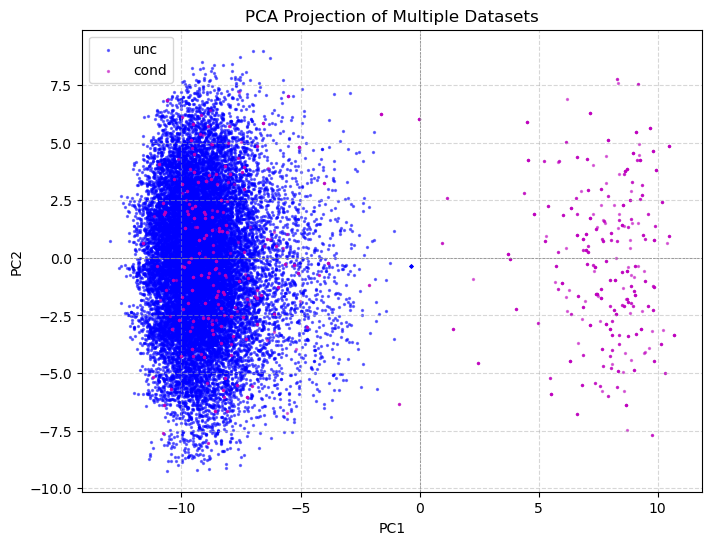

In [17]:
plot_pca_scatter([proj_unc, proj_cond], colors = ['b', 'm'], legend = ['unc', 'cond'])

**Third Test:** We will compare the conditional and unconditional to the raw data in PCA space